In [ ]:
import os
os.getcwd()

In [ ]:
zip_path = '../gdrive/MyDrive/Kaggle/chest-xray-pneumonia.zip'
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
!cp '../gdrive/MyDrive/Kaggle/chest-xray-pneumonia.zip' '/content'

In [ ]:
!unzip -q 'chest-xray-pneumonia.zip'

In [ ]:
# !pip install colorama

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import pyplot as plt
import sys
# import colorama
from collections import OrderedDict
from matplotlib import pyplot as plt 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.set_printoptions(precision=3)
import torchvision
import os
import sklearn.metrics as met

num_workers = 2
batch_size = 128

device = torch.device('cuda') 

In [2]:
PATH = '../input/chest-xray-pneumonia/chest_xray/'

default_transform = transforms.Compose([transforms.Grayscale(1), transforms.Resize((216, 216)), transforms.ToTensor()])
train_data = datasets.ImageFolder(PATH + 'train', transform=default_transform)
test_data = datasets.ImageFolder(PATH + 'test', transform=default_transform)
val_data = datasets.ImageFolder(PATH + 'val', transform=default_transform)


def random_transforms():
    all_to_apply = [transforms.Grayscale(1)]
    all_to_apply.append(transforms.RandomRotation(degrees=np.random.randint(2, 15)))
#     all_to_apply.append(transforms.RandomAutocontrast(0.7))
    all_to_apply.append(transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))
    all_to_apply.append(transforms.GaussianBlur(kernel_size=(3, 3), sigma=(np.random.uniform(0.1, 0.2), np.random.randint(1, 2))))
    all_to_apply.append(transforms.RandomHorizontalFlip(p=0.5))
    all_to_apply.append(transforms.Resize((216, 216)))
    all_to_apply.append(transforms.ToTensor())
    return all_to_apply
        
aug1_transforms = transforms.Compose(random_transforms())
aug1_train_data = datasets.ImageFolder(PATH + 'train', transform=aug1_transforms)
        
aug2_transforms = transforms.Compose([transforms.Grayscale(1), transforms.RandomRotation(degrees=np.random.randint(2, 5)),\
                                      transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), transforms.Resize((216, 216)),\
                                      transforms.ToTensor()])
aug2_train_data = datasets.ImageFolder(PATH + 'train', transform=aug2_transforms)
        
aug3_transforms = transforms.Compose([transforms.Grayscale(1), transforms.Resize((216, 216)),\
                                      transforms.RandomAffine(degrees=3, translate=(0.08, 0.08)), transforms.RandomCrop(size=180),\
                                      transforms.Resize((216, 216)),  transforms.ToTensor()])
aug3_train_data = datasets.ImageFolder(PATH + 'train', transform=aug3_transforms)

aug4_transforms = transforms.Compose([transforms.Grayscale(1), transforms.Resize((216, 216)),\
                                      transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)), transforms.RandomCrop(size=160),\
                                      transforms.Resize((216, 216)),  transforms.ToTensor()])
aug4_train_data = datasets.ImageFolder(PATH + 'train', transform=aug4_transforms)

aug5_transforms = transforms.Compose([transforms.Grayscale(1), transforms.Resize((216, 216)),\
                                      transforms.GaussianBlur(kernel_size=(5, 5), sigma=(np.random.uniform(0.05, 0.15), np.random.randint(1, 2))),\
                                      transforms.RandomAffine(degrees=7, translate=(0.2, 0.2)), transforms.CenterCrop(size=160),\
                                      transforms.RandomHorizontalFlip(p=0.3),\
                                      transforms.Resize((216, 216)),  transforms.ToTensor()])
aug5_train_data = datasets.ImageFolder(PATH + 'train', transform=aug5_transforms)

aug6_transforms = transforms.Compose([transforms.Grayscale(1),\
                                      transforms.RandomAffine(degrees=3, translate=(0.1, 0.1)), transforms.Resize((216, 216)),\
                                      transforms.RandomCrop(size=160), transforms.RandomHorizontalFlip(p=0.3),\
                                      transforms.Resize((216, 216)),  transforms.ToTensor()])
aug6_train_data = datasets.ImageFolder(PATH + 'train', transform=aug6_transforms)


for i, img in enumerate(os.listdir(PATH + 'train/PNEUMONIA')):
    path = os.path.join(PATH + 'train/PNEUMONIA', img)
    if np.random.uniform() < 0.5:
        train_data.imgs.remove((path, 1))
    if np.random.uniform() < 0.667:
        aug1_train_data.imgs.remove((path, 1))
    if np.random.uniform() < 0.8:
        aug2_train_data.imgs.remove((path, 1))
    if np.random.uniform() < 0.7:
        aug3_train_data.imgs.remove((path, 1))
    if np.random.uniform() < 0.7:
        aug4_train_data.imgs.remove((path, 1))
    if np.random.uniform() < 0.7:
        aug5_train_data.imgs.remove((path, 1))
    if np.random.uniform() < 0.7:
        aug6_train_data.imgs.remove((path, 1))
    

In [3]:
print(aug1_train_data.class_to_idx)
print(aug2_train_data.class_to_idx)
print(aug3_train_data.class_to_idx)
print(aug4_train_data.class_to_idx)
print(aug5_train_data.class_to_idx)
print(aug6_train_data.class_to_idx)
print(train_data.class_to_idx)
print(test_data.class_to_idx)
print(val_data.class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [4]:
def sampler(dataset):
    return SubsetRandomSampler(np.random.choice(np.array(list(range(len(dataset)))), size=len(dataset), replace=False))

def loader(dataset):
    return torch.utils.data.DataLoader(dataset, 
									   batch_size = batch_size,
                                       sampler = sampler(dataset),
                                       num_workers = num_workers)

train_loader = loader(train_data)

aug1_loader, aug2_loader, aug3_loader, aug4_loader, aug5_loader, aug6_loader =\
loader(aug1_train_data), loader(aug2_train_data), loader(aug3_train_data), loader(aug4_train_data),\
                                                  loader(aug5_train_data), loader(aug6_train_data)

val_loader = torch.utils.data.DataLoader(val_data, batch_size = 16,\
                                                   sampler = sampler(val_data),\
                                                   num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                                     num_workers = num_workers)

In [5]:
# for i, (img, l) in enumerate(train_loader):
#     if i > 5:
#         break
#     print(l)


In [6]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# from torchvision.transforms.functional import to_tensor, to_pil_image
# device = torch.device('cpu')
# def visualize_images(dataloader, device):
#     data, labels = next(iter(dataloader))
#     data, labels = data[:12].to(device), labels[:12]
#     # predictions = model(data).max(1)[1]
    
#     # predictions, data = predictions.cpu(), data.cpu()
#     plt.figure(figsize=(20,12))
#     for i in range(12):
#         img = data.squeeze(1)[i]
#         plt.subplot(2, 6, i+1)
#         plt.imshow(to_pil_image(img), cmap="gray", interpolation="none")
#         plt.xlabel(labels[i].item(), fontsize=18)
#         plt.xticks([])
#         plt.yticks([])    
    
# visualize_images(train_loader, device)

In [7]:
# transformations = transforms.Compose([
#     transforms.Resize((216, 216)),
#     transforms.ToTensor()
# ])

# train_dataM = datasets.MNIST('./data', 
#                             train = True, 
#                             download = False,
#                             transform = transformations)

# test_dataM = datasets.MNIST('./data', 
#                             train = False, 
#                             download = False,
#                             transform = transformations)

# train_loaderM = torch.utils.data.DataLoader(train_dataM, batch_size=256, shuffle=True)
# test_loaderM = torch.utils.data.DataLoader(test_dataM, batch_size=1024, shuffle=False)

In [11]:
class ResBlock1(nn.Module):
    def __init__(self, init_pad, k_size, s1, s2, skip_resize, pools, poolstride, inchan, bnorm2depth, skp_in_ch, a, b):
        super(ResBlock1, self).__init__()
        self.zpad = nn.ZeroPad2d(init_pad)
        self.c1 = nn.Conv2d(in_channels=inchan, out_channels=16, kernel_size=(k_size, k_size), stride=s1)
        nn.init.kaiming_normal_(self.c1.weight)
        self.bnorm = nn.BatchNorm2d(16)        
        self.c2 = nn.Conv2d(in_channels=16, out_channels=a, kernel_size=(k_size, k_size), stride=s2)
        nn.init.kaiming_normal_(self.c2.weight)
        self.bnormc2 = nn.BatchNorm2d(a)
        self.downConv = nn.Conv2d(in_channels=skp_in_ch, out_channels=a, kernel_size=(pools, pools), stride=poolstride)
        nn.init.kaiming_normal_(self.downConv.weight)
        self.dro = nn.Dropout(0.4)
        self.resize = transforms.Resize((skip_resize, skip_resize))
        self.bnorm2 = nn.BatchNorm2d(bnorm2depth)

    def forward(self, x):
        out = self.zpad(x)
        out = self.c1(out)
        out = self.bnorm(out)
        out = F.relu(out)
        out = self.c2(out)
        out = self.bnormc2(out)
        new = self.bnorm2(self.downConv(x))
        new = self.resize(new)
        out = out + new
        out = F.relu(out)
#         out = self.dro(out)
        return out
    
    
    
class ResBlock2(nn.Module):
    def __init__(self, init_pad, k_size, s1, s2, skip_resize, pools, poolstride, inchan, bnorm2depth, skp_in_ch, a, b):
        super(ResBlock2, self).__init__()
        self.zpad = nn.ZeroPad2d(init_pad)
        self.c1 = nn.Conv2d(in_channels=inchan, out_channels=b, kernel_size=(k_size, k_size), stride=s1)
        nn.init.kaiming_normal_(self.c1.weight)
        self.bnorm = nn.BatchNorm2d(b)        
        self.c2 = nn.Conv2d(in_channels=b, out_channels=b, kernel_size=(k_size, k_size), stride=s2)
        nn.init.kaiming_normal_(self.c2.weight)
        self.bnormc2 = nn.BatchNorm2d(b)
        self.downConv = nn.Conv2d(in_channels=skp_in_ch, out_channels=b, kernel_size=(pools, pools), stride=poolstride)
        nn.init.kaiming_normal_(self.downConv.weight)
        self.dro = nn.Dropout(0.4)
        self.resize = transforms.Resize((skip_resize, skip_resize))
        self.bnorm2 = nn.BatchNorm2d(bnorm2depth)
        
    def forward(self, x):
        out = self.zpad(x)
        out = self.c1(out)
        out = self.bnorm(out)
        out = F.relu(out)
        out = self.c2(out)
        out = self.bnormc2(out)
        new = self.bnorm2(self.downConv(x))
        new = self.resize(new)
        out = out + new
        out = F.relu(out)
#         out = self.dro(out)
        return out
    
    
class ResNet(nn.Module):
    def __init__(self, x, y):
        super(ResNet, self).__init__()
        self.resb1 = ResBlock1(init_pad=5, k_size=7, s1=3, s2=1, skip_resize=68, pools=5, poolstride=3, inchan=1, bnorm2depth=x, skp_in_ch=1, a=x, b=y)
        self.resb2 = ResBlock2(init_pad=0, k_size=5, s1=1, s2=1, skip_resize=60, pools=3, poolstride=1, inchan=x, bnorm2depth=y, skp_in_ch=x, a=x, b=y)
        self.resb3 = ResBlock2(init_pad=0, k_size=3, s1=1, s2=1, skip_resize=56, pools=5, poolstride=1, inchan=y, bnorm2depth=y, skp_in_ch=y, a=x, b=y)
        self.f5 = nn.Linear(in_features=125440, out_features=600)
        nn.init.kaiming_normal_(self.f5.weight)
        self.f6 = nn.Linear(in_features=600, out_features=2)
        nn.init.kaiming_normal_(self.f6.weight)
        self.dro = nn.Dropout(0.4)
        
    def forward(self, imgs):
        out = self.resb1(imgs)
        out = self.resb2(out)
        out = self.resb3(out)
        out = out.view(out.shape[0], -1)
        out = self.f5(out)
        out = F.relu(out)
#         out = self.dro(out)
        out = self.f6(out)
        out = F.softmax(out, dim=-1)
        return out

In [12]:
conv_net = ResNet(x=24, y=40)

In [13]:
input = torch.randn(1, 1, 216, 216)  # batch_size, num_channels, height, width
out = conv_net(input)
# print("Log-Probabilities: \n%s\n" % out)
# print("Probabilities: \n%s\n" % torch.exp(out))
print("out.shape: \n%s" % (out.shape,))

out.shape: 
torch.Size([1, 2])


In [14]:
print(conv_net)

ResNet(
  (resb1): ResBlock1(
    (zpad): ZeroPad2d(padding=(5, 5, 5, 5), value=0.0)
    (c1): Conv2d(1, 16, kernel_size=(7, 7), stride=(3, 3))
    (bnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c2): Conv2d(16, 24, kernel_size=(7, 7), stride=(1, 1))
    (bnormc2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downConv): Conv2d(1, 24, kernel_size=(5, 5), stride=(3, 3))
    (dro): Dropout(p=0.4, inplace=False)
    (resize): Resize(size=(68, 68), interpolation=PIL.Image.BILINEAR)
    (bnorm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resb2): ResBlock2(
    (zpad): ZeroPad2d(padding=(0, 0, 0, 0), value=0.0)
    (c1): Conv2d(24, 40, kernel_size=(5, 5), stride=(1, 1))
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (c2): Conv2d(40, 40, kernel_size=(5, 5), stride=(1, 1))
    (bnormc2): BatchNorm2d(40, eps=1e-05, mo

In [15]:
named_params = list(conv_net.named_parameters())
print("len(params): %s\n" % len(named_params))
for name, param in named_params:
    print("%s:\t%s" % (name, param.shape))

len(params): 40

resb1.c1.weight:	torch.Size([16, 1, 7, 7])
resb1.c1.bias:	torch.Size([16])
resb1.bnorm.weight:	torch.Size([16])
resb1.bnorm.bias:	torch.Size([16])
resb1.c2.weight:	torch.Size([24, 16, 7, 7])
resb1.c2.bias:	torch.Size([24])
resb1.bnormc2.weight:	torch.Size([24])
resb1.bnormc2.bias:	torch.Size([24])
resb1.downConv.weight:	torch.Size([24, 1, 5, 5])
resb1.downConv.bias:	torch.Size([24])
resb1.bnorm2.weight:	torch.Size([24])
resb1.bnorm2.bias:	torch.Size([24])
resb2.c1.weight:	torch.Size([40, 24, 5, 5])
resb2.c1.bias:	torch.Size([40])
resb2.bnorm.weight:	torch.Size([40])
resb2.bnorm.bias:	torch.Size([40])
resb2.c2.weight:	torch.Size([40, 40, 5, 5])
resb2.c2.bias:	torch.Size([40])
resb2.bnormc2.weight:	torch.Size([40])
resb2.bnormc2.bias:	torch.Size([40])
resb2.downConv.weight:	torch.Size([40, 24, 3, 3])
resb2.downConv.bias:	torch.Size([40])
resb2.bnorm2.weight:	torch.Size([40])
resb2.bnorm2.bias:	torch.Size([40])
resb3.c1.weight:	torch.Size([40, 40, 3, 3])
resb3.c1.bias:	to

In [24]:
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
test_acc_all, train_acc_all, val_acc_all, train_loss_all = [], [], [], []
acc_all, f1_all, prec_all, rec_all = [], [], [], []

def train_cnn(model, train_loader, aug1_loader, aug2_loader, aug3_loader, aug4_loader, aug5_loader, aug6_loader, test_loader, val_loader, device, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCELoss()
    scheduler = ExponentialLR(optimizer, gamma=0.75)
    blocks, best_acc = 0, 0
    for epoch in range(num_epochs):
        print("=" * 25, "Starting epoch %d" % (epoch + 1), "=" * 25)
        names = ['train_loader', 'aug1_loader', 'aug2_loader', 'aug3_loader', 'aug4_loader', 'aug5_loader', 'aug6_loader']
        for d_idx, dataloader in enumerate([train_loader, aug1_loader, aug2_loader, aug3_loader, aug4_loader, aug5_loader, aug6_loader]):
            for batch_idx, (data, labels) in enumerate(dataloader):
                model.train()
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[:, 1].to(torch.float64), labels.to(torch.float64))
                loss.backward()
                optimizer.step()
                if batch_idx % 15 == 0:
                    print("\nstarting batch %d/%d, Loss=%.4f" % (batch_idx, len(dataloader), loss.item()), end=' ')
                    print('on: ', names[d_idx])
                    train_acc = accuracy(model, train_loader, device)
                    val_acc = accuracy(model, val_loader, device)
                    test_acc = accuracy(model, test_loader, device)
                    if val_acc > best_acc:
                        torch.save(model.state_dict(), 'model.pt')
                        best_acc = val_acc
                    print(colorama.Fore.GREEN, "Accuracy on training: %.2f%%" % (100*train_acc))
                    print("Accuracy on val: %.2f%%" % (100*val_acc))                
                    print("Accuracy on test: %.2f%%" % (100*test_acc), colorama.Fore.RESET); 
                    test_acc_all.append(test_acc); train_acc_all.append(train_acc); val_acc_all.append(val_acc); train_loss_all.append(loss.item());
                    blocks += 1
        acc, f1, prec, rec = score(model, test_loader, device)
        acc_all.append(acc); f1_all.append(f1); prec_all.append(prec); rec_all.append(rec);
        plot_train(test_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks)
        scheduler.step()
        if (epoch+1) % 3 == 0:
            plot_scores(acc_all, f1_all, prec_all, rec_all, epoch=epoch+1)
            

In [17]:
def accuracy(model, dataloader, device):
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            predictions = model(data).max(1)[1]
            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
    return num_correct / num_samples

def print_score(y_test, pred):
    print('Accuracy:  ', met.accuracy_score(y_test, pred))
    print('F1_score:  ', met.f1_score(y_test, pred))
    print('Precision: ', met.precision_score(y_test, pred))
    print('Recall:    ', met.recall_score(y_test, pred))
    
def score(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    print_score(y_test, pred)
    return met.accuracy_score(y_test, pred), met.f1_score(y_test, pred),\
    met.precision_score(y_test, pred),\
    met.recall_score(y_test, pred)

def plot_conmat(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    c = met.confusion_matrix(y_test, pred)
    disp = met.ConfusionMatrixDisplay(c)
    plt.figure(figsize=(10, 6))
    disp.plot()

In [18]:
def plot_train(test_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks):
    plt.figure(figsize=(10, 6))
    x = np.arange(blocks)
    plt.plot(x, train_acc_all, label='train accuracy');
    plt.plot(x, val_acc_all, label='validation accuracy');
    plt.plot(x, test_acc_all, label='test accuracy');
#     plt.plot(reg, mean_f1, label='F1_score');
    plt.xlabel('15-Batch training blocks');
    plt.ylabel('Model accuracy');
    plt.title('Model prediction accuracy by training batches');
    plt.legend();
    plt.show();
    
def plot_scores(acc_all, f1_all, prec_all, rec_all, epoch):
    plt.figure(figsize=(10, 6))
    x = np.arange(epoch)
    plt.plot(x, acc_all, label='test accuracy');
    plt.plot(x, f1_all, label='test F1 score');
    plt.plot(x, prec_all, label='test precision');
    plt.plot(x, rec_all, label='test_recall');
    plt.xlabel('Number of trained epochs');
    plt.ylabel('Model scores');
    plt.title('Model prediction scores on test data by training epochs');
    plt.legend();
    plt.show();

========================= Starting epoch 1 =========================

starting batch 0/26, Loss=0.9711 on:  train_loader
 Accuracy on training: 40.77%
Accuracy on val: 50.00%
Accuracy on test: 37.18% 

starting batch 15/26, Loss=0.2674 on:  train_loader
 Accuracy on training: 68.75%
Accuracy on val: 56.25%
Accuracy on test: 63.62% 

starting batch 0/21, Loss=0.5276 on:  aug1_loader
 Accuracy on training: 91.65%
Accuracy on val: 75.00%
Accuracy on test: 74.20% 

starting batch 15/21, Loss=0.2379 on:  aug1_loader
 Accuracy on training: 95.58%
Accuracy on val: 62.50%
Accuracy on test: 75.80% 

starting batch 0/17, Loss=0.2281 on:  aug2_loader
 Accuracy on training: 96.31%
Accuracy on val: 62.50%
Accuracy on test: 77.72% 

starting batch 15/17, Loss=0.1136 on:  aug2_loader
 Accuracy on training: 96.82%
Accuracy on val: 81.25%
Accuracy on test: 83.17% 

starting batch 0/20, Loss=0.3515 on:  aug3_loader
 Accuracy on training: 94.46%
Accuracy on val: 93.75%
Accuracy on test: 86.70% 

starting

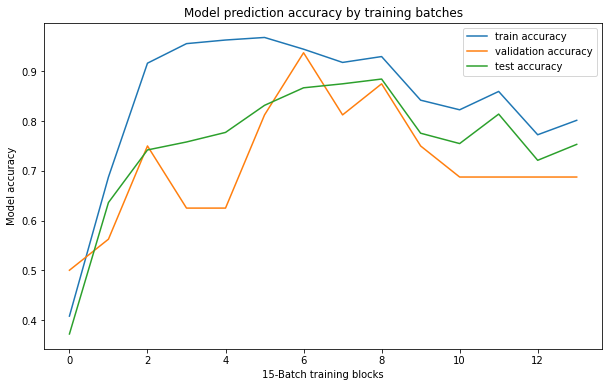

========================= Starting epoch 2 =========================

starting batch 0/26, Loss=0.2791 on:  train_loader


KeyboardInterrupt: 

In [19]:
device = torch.device('cuda') # if torch.cuda.is_available() else 'cpu')
conv_net = conv_net.to(device)

train_cnn(conv_net, train_loader, aug1_loader, aug2_loader, aug3_loader, aug4_loader, aug5_loader, aug6_loader, test_loader, val_loader, device, num_epochs=30, lr=1e-5)

In [21]:
cn = ResNet(x=24, y=40)
cn.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [22]:
cn = cn.to(device)
accuracy(cn, test_loader, device)

0.8846153846153846

<Figure size 720x432 with 0 Axes>

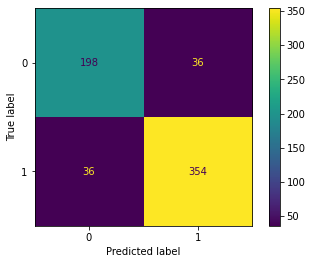

In [23]:
plot_conmat(cn, test_loader, device);